In [5]:
import numpy as np
import pandas as pd
import pickle
from sklearn import datasets # sklearn comes with some toy datasets to practice
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import json
from spotipy.oauth2 import SpotifyClientCredentials
import config #file with client_id and secret for the Spotify API
import spotipy
from IPython.display import IFrame

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    kmeans = KMeans()  # Equivalent to setting n_init=10 (default)

In [6]:
#reading df with Spotify songs extracted with API (based on 1800-1900 songs)
df=pd.read_csv("https://raw.githubusercontent.com/okravtsova123/SongRecommendationML-k-means-/main/songs_with_AF.csv")
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= config.client_id, client_secret= config.client_secret))

In [16]:
#FUNCTIONS

#FUNCTIONS FOR PREPING THE FILE AND GETTING CLUSTERS

def input_url():
    url=input("please input url with CSV with all the songs:")
    return prep_csv(url)

def prep_csv(url):
    df=pd.read_csv(url)
    #dropping columns for analysis
    columns_to_drop=['type', 'uri','track_href', 'analysis_url', 'duration_ms', 'time_signature']
    X=df.drop(columns_to_drop, axis=1)
    # setting indexes as IDs - convinient for scaling
    X.set_index("id", inplace=True)
    return scaling_fit(X)

def scaling_fit(df):
    #scaling
    df=df
    scaler=StandardScaler()
    scaler.fit(df)
    x=0
    return scaling_transform(df, x, scaler)

def scaling_transform(df, x, scaler):
    ids=df.index
    scaler=scaler
    scaled_df=pd.DataFrame(scaler.transform(df), columns=df.columns)
    scaled_df=scaled_df.set_index(ids)
    if x==1:
        return recomendation(scaled_df, scaler)
    else:
        return training_model(scaled_df, scaler)

def training_model(scaled_df, scaler): #NEED TO FIGURE OUT HOW TO CHECK N OF CLUSTERS AUTOMATICALLY
    n=int(input('how many clusters do you want to have?'))
    scaler=scaler
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(scaled_df)
    scaled_df=scaled_df
    #identifying clusters
    clusters = kmeans.predict(scaled_df)
    clusters_df=pd.DataFrame(clusters).value_counts().sort_index()

    #checking whether we need to check the amount of clusters
    a=int(input("what amount of clusters do you want to check? FROM: "))
    b=int(input("TO:"))
    
    K = range(a, b)
    silhouette = []
    print("")
    print("that's the clusters and the amount of songs in each cluster:")
    print(clusters_df)

    for k in K:
        kmeans = KMeans(n_clusters=k,
                    random_state=42, n_init=10)
        kmeans.fit(scaled_df)
    
        silhouette.append(silhouette_score(scaled_df, kmeans.predict(scaled_df)))
    
    plt.plot(K, silhouette, 'bx-')
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.xticks(np.arange(min(K), max(K)+1, 1.0))
    plt.title('Silhouette Method showing the optimal k')
    plt.figure(figsize=(16,8))
    plt.show()
    return change_clusters_check(scaled_df, clusters, scaler)

def change_clusters_check(scaled_df, clusters, scaler):
    check=0
    scaler=scaler
    scaled_df=scaled_df
    clusters=clusters

    while check not in ("yes", "no"):
        check=input("do you want to change the number of clusters?")
    if check=="yes":
        return training_model(scaled_df)
    else:
        scaled_df_w_clusters=scaled_df
        scaled_df_w_clusters['cluster']=clusters
        print("ready, now you can use user_input() function")
        return scaled_df_w_clusters, scaler

    
#FUNCTIONS FOR PREPING THE FILE AND GETTING CLUSTERS    
def user_input():
    song_input=input("input your favourite song:")
    song_input=song_input.lower()
    return search_spotify(song_input)

def search_spotify(song):
    song_name=song
    result=sp.search(q=song_name,type="track",market="GB")
    song_id=result['tracks']['items'][0]['id']
    return extracting_AF(song_id)

def extracting_AF(id_):
    song_af=pd.DataFrame(sp.audio_features(id_))
    song_af=song_af.drop(['type', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature'], axis=1)
    song_af=song_af.set_index("id")
    x=1
    return scaling_transform(song_af, x)

def recomendation(scaled_df):
    #getting the cluster
    cluster_for_rec=kmeans.predict(scaled_df)[0]
    #checking df with this cluster and extracting sample
    recomended_song=scaled_df_w_clusters[scaled_df_w_clusters['cluster']==cluster_for_rec].sample()
    recomended_song_id=recomended_song.index[0]
    #playing recommended song
    recomended_song_id = str(recomended_song_id)
    return IFrame(src="https://open.spotify.com/embed/track/"+recomended_song_id,
                 width="320", height="80", frameborder="0",allowtransparency="true",allow="encrypted-media")

how many clusters do you want to have?20


C:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


what amount of clusters do you want to check? FROM: 10
TO:15

that's the clusters and the amount of songs in each cluster:
0      94
1     159
2      75
3     125
4     107
5      56
6     113
7     160
8      66
9     118
10    110
11     68
12     85
13    142
14     89
15     92
16     43
17     50
18     85
19     28
Name: count, dtype: int64


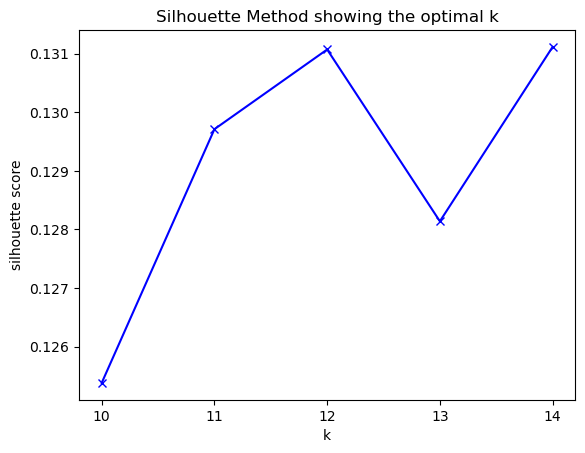

<Figure size 1600x800 with 0 Axes>

do you want to change the number of clusters?no
ready, now you can use user_input() function


ValueError: too many values to unpack (expected 2)

In [19]:
#SAVE THE RESULT OF A FUNCTION PREP_CSV OR INPUT_URL AS scaled_df_w_clusters OR THE USER INPUT WON'T WORK
scaled_df_w_clusters, scaler =prep_csv("https://raw.githubusercontent.com/okravtsova123/SongRecommendationML-k-means-/main/songs_with_AF.csv")

In [18]:
user_input()

input your favourite song:numb


TypeError: scaling_transform() missing 1 required positional argument: 'scaler'